In [7]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 16.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 944.1/944.1 kB 12.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [50]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [51]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Import data into tensorflow dataset object

In [91]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [92]:
dataset.class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [93]:
len(dataset)

68

In [94]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [97]:
class_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


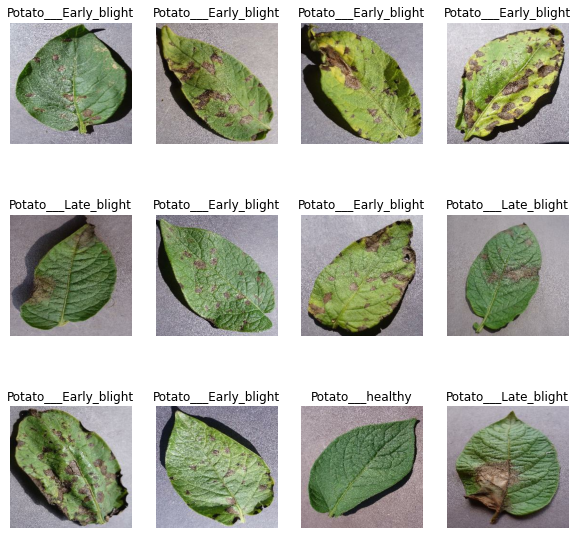

In [98]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [99]:
len(dataset)

#68 * 32 (batch#)

68

In [61]:
train_size = 0.8 #training 80%, 10% validation (used during training process), 10% test
len(dataset)*train_size

54.400000000000006

In [62]:
train_ds = dataset.take(54) #take first 54 batches, like [:54]
len(train_ds)

54

In [63]:
test_ds = dataset.skip(54) #like in arr[54:]
len(test_ds)

14

In [64]:
val_size=0.1 #validation size
len(dataset)*val_size

6.800000000000001

In [65]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [66]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [67]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [68]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [69]:
#Cache, Shuffle, and Prefetch the Dataset

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

## Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it



In [70]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [71]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [72]:
# Applying data augmentation to train dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [73]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [74]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

##  Compiling the Model
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [75]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=5,
)

Epoch 1/5
54/54 [==============================] - 125s 2s/step - loss: 0.9504 - accuracy: 0.4442 - val_loss: 0.9186 - val_accuracy: 0.4427
Epoch 2/5
54/54 [==============================] - 115s 2s/step - loss: 0.7686 - accuracy: 0.6565 - val_loss: 0.6805 - val_accuracy: 0.7240
Epoch 3/5
54/54 [==============================] - 134s 2s/step - loss: 0.4768 - accuracy: 0.8035 - val_loss: 0.3434 - val_accuracy: 0.8542
Epoch 4/5
54/54 [==============================] - 135s 3s/step - loss: 0.3182 - accuracy: 0.8626 - val_loss: 0.2043 - val_accuracy: 0.9219
Epoch 5/5
54/54 [==============================] - 132s 2s/step - loss: 0.2550 - accuracy: 0.9037 - val_loss: 0.1413 - val_accuracy: 0.9323


In [77]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 9s 560ms/step - loss: 0.2399 - accuracy: 0.8984


In [78]:
scores

[0.23987233638763428, 0.8984375]

# Plotting the Accuracy and Loss Curves


In [79]:
history

In [80]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [81]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
type(history.history['loss'])

list

In [83]:
len(history.history['loss'])

5

In [84]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9113273620605469,
 0.6775326132774353,
 0.43940338492393494,
 0.30181148648262024,
 0.23500630259513855]

In [125]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

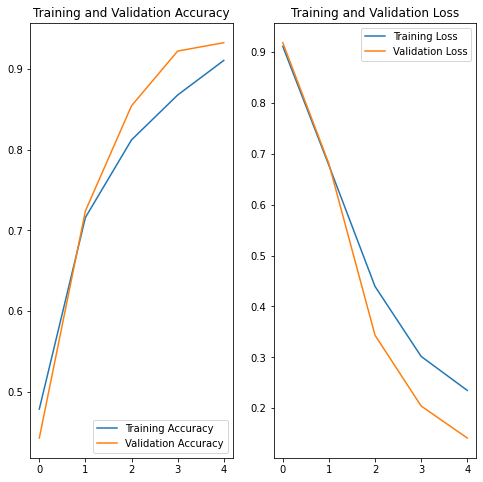

In [126]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#x-axis: # of epoch. Due to my computer cpu capacity, I limited my epoch to 5. 

# Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


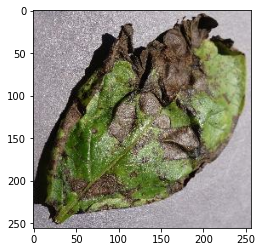

In [127]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8') #convert tensor to numpy
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])]) #Returns the indices of the maximum values along an axis.

# Write a function for inference

In [102]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Now run inference on few sample images

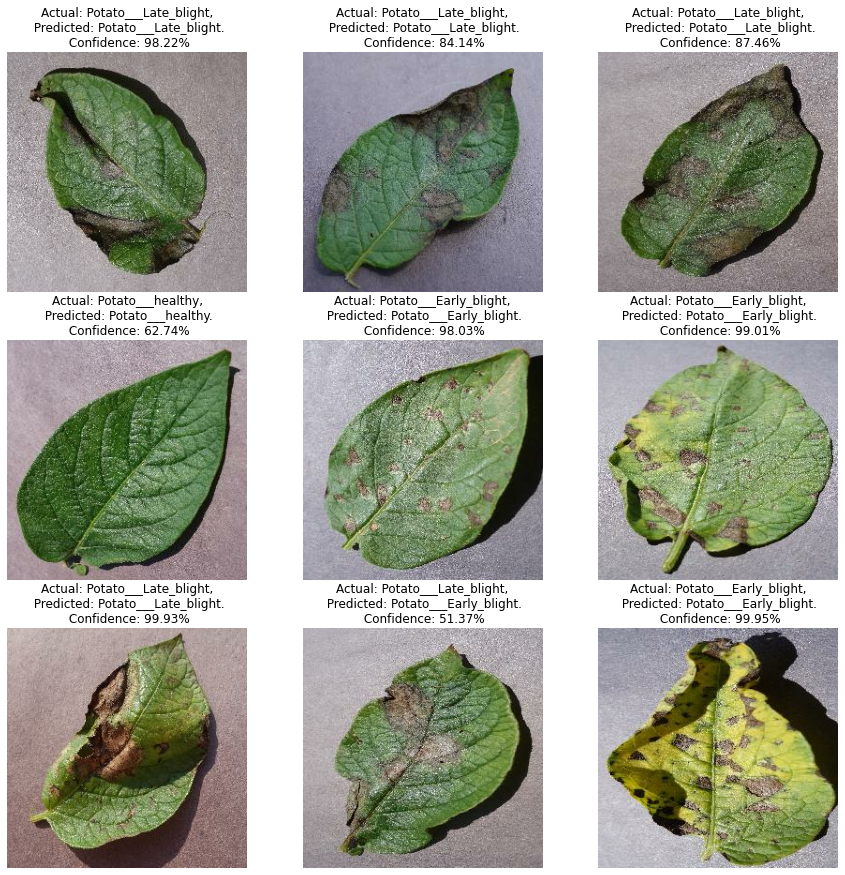

In [103]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model
We append the model to the list of models as a new version

In [117]:
model_version =1 
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


In [119]:
#import os
#model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
#model.save(f"../models/{model_version}")

In [118]:
model.save("../potatoes.h5")